# Andy Haldane speech analysis

The task below is to use Natural Language processing techniques to analyse and summarise key risks mentioned in the speeches of former Chief Economist of the Bank of England Andy Haldane. The speeches can be found here: https://www.bankofengland.co.uk/news/speeches. 

In total, 55 speeches were analysed.


## Data import
The data was imported from PDFs of the speeches as a long string. 

Cleansing the data was required to improve the performance of the analysis. The data cleaning performed included: 
- removing page numbers
- removing hyperlinks
- removing puncuation (some extra punction was added additional to the default list, like curly speech marks)
- stopwords
- lemmatisation of the text - standardising words, for example banks --> bank

During the analysis, a handful more stopwords were added to the default list to increase the performance of the analysis. The added stopwords were: 

- central, bank, et, al, et al, uk, chart, s 

At the end of this stage, the corpus consisted of a list of 55 strings of the cleansed text from the speeches.

In [6]:
from file_import import import_pdf
import glob
from tfidf import *
from co_occurance import *
import numpy as np

corpus=[]
publishing_dates = []
for file in list(glob.glob('speeches/*.pdf')):
    pdf, d = import_pdf(file)
    corpus.append(pdf)
    publishing_dates.append(d)


## Term Frequency - Inverse Document Frequency
I chose TF-IDF as a way to get an initial indication of the key risks mentioned in Andy Haldane's speeches. I ran the TF-IDF algorithm across the whole corpus and selected the top 10 results from each speech (550 results total). Then, any results that appeared in more than 1 speech were added together to get a total score for each identified word across all 55 speeches. I selected the top 25 of these to assess whether any risks were identified using this method 

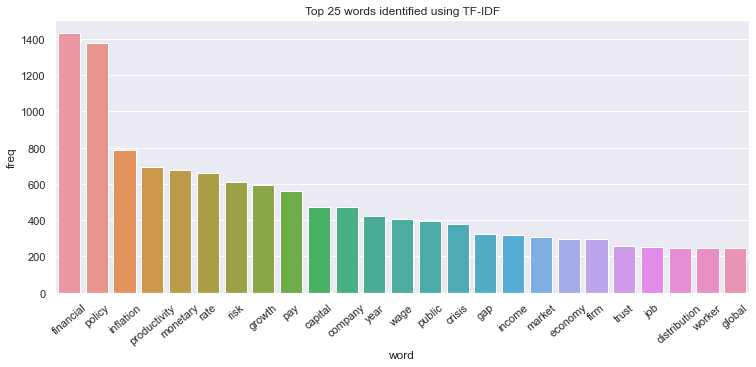

In [12]:
TFIDFvectorizer, feature_names = TFIDF(corpus)
results = corpus_resuts(corpus, TFIDFvectorizer, feature_names, 10)

def corpus_totals(corp, tfidf_results, top_n):
    totals = dict()
    for i in range(len(corp)):
        
        text=corpus[i].split()
        
        for j in range(len(tfidf_results[i])):
            tfidf_word = tfidf_results[i][j]
            count = text.count(tfidf_word)
            
            if tfidf_word in totals:
                totals[tfidf_word] += count
                
            else:
                totals[tfidf_word] = count
                
    totals = dict(sorted(totals.items(), key=lambda item: item[1], reverse=True))
    totals  = {k: totals[k] for k in list(totals)[:top_n]}
    
    return totals

top_words = corpus_totals(corpus, results, 25)
top_words = pd.DataFrame(top_words.items(), columns=['word','freq'])

import seaborn as sns
from matplotlib import pyplot as plt
sns.set(rc={'figure.figsize':(10.7,5.27)})
sns.barplot(x='word', y='freq', data=top_words).set_title('Top 25 words identified using TF-IDF')
plt.xticks(rotation=40)
plt.tight_layout()
plt.show()


Based on the results of the TF-IDF, although 15 I deemed to not be risk related, I identified 10 risk words from the top 25 of the TF-IDF keyword extraction:
1. inflation
2. productivity
4. growth
5. pay
6. capital
7. wage
9. gap
10. income
11. trust
12. distribution


I expected Brexit or Covid to feature in this list and was surprised they did not appear in the chart above.

In [8]:
risks = ['inflation',
         'productivity',
         'growth',
         'pay',
         'capital',
         'wage', 
         'gap',
         'income',
         'trust',
         'distribution']

### Time series plot of risks identified
I next wanted to investigate how these risks might have evolved over time using the dates of publication from the speech PDFs

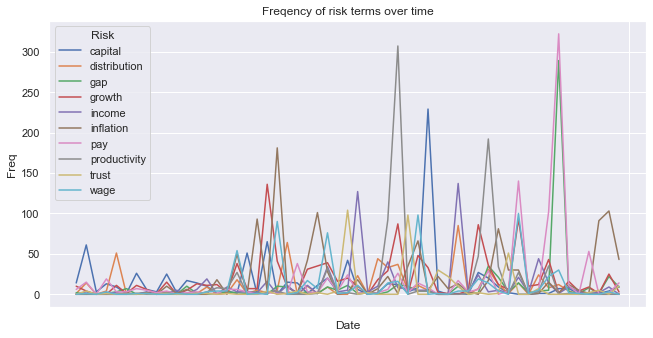

In [11]:
def risks_time_series(corp, risk):
    time_series = pd.DataFrame(columns=['Date', 'Freq', 'Risk'])
    
    for r in risk:
        r_count = []
        
        for doc in corp:
            r_count.append(doc.count(r))
        
        r_ts = pd.DataFrame([publishing_dates, r_count]).transpose()
        r_ts.columns = ['Date', 'Freq']
        r_ts['Risk'] = r
        
        time_series = time_series.append(r_ts)
        
    return time_series

risk_ts = risks_time_series(corpus, risks)

#wide data for  plotting
risk_ts = risk_ts.pivot("Date", "Risk", "Freq")
sns.set(rc={'figure.figsize':(10.7,5.27)})
sns.lineplot(data=risk_ts, dashes=False).set_title('Freqency of risk terms over time')
plt.ylabel('Freq')
plt.xticks('')
plt.show()

(For readibility, the x labels have been left blank)

There doesn't appear to be a discernible pattern in the the trend of various risk words. A reason for this could be the wide variety of speechs Andy Haldane gives - seminars, annual speeches etc. Restricting the corpus to only speeches to acedemic institutions for example might yield better results.

## Co-Occurrance of words

In [ ]:
highest_coo = pd.DataFrame()

def top_coocurrance_words(doc, target):
    
    vocab_dict = build_vocabulary(doc)
    
    if target in vocab_dict.keys():
    
        co_ocurrence_vectors = pd.DataFrame(
            np.zeros([len(vocab_dict), len(vocab_dict)]),
            index = vocab_dict.keys(),
            columns = vocab_dict.keys()
        )
        
        co_ocurrence_vectors = build_context(doc, 5, co_ocurrence_vectors)
        top_words = co_ocurrence_vectors.loc[target].sort_values(ascending=False).head(10)
        top_words = top_words.rename('Freq')
        top_words = pd.DataFrame(top_words)
        top_words = top_words.rename_axis('Co-Oc').reset_index()
        top_words['Target'] = target
        
        return top_words

risk_terms = ['risk', 'crisis', 'uncertainty']

for target in risk_terms:
    for doc in corpus:
        
        top_values = top_coocurrance_words(doc, target)
        highest_coo = highest_coo.append(top_values)

highest_coo = highest_coo.groupby(['Target', 'Co-Oc']).sum().sort_values('Freq', ascending=False)
highest_coo = highest_coo.reset_index('Co-Oc')

x=highest_coo.groupby('Target').head(20)

for rt in risk_terms:
    title = 'Top 20 terms within 5 words of: ' + rt
    sns.barplot(data=x.loc[rt], x='Co-Oc', y='Freq').set_title(title)    
    plt.xticks(rotation=40)
    plt.show()